In [1]:
from __future__ import annotations
## MODEL CODE + EXTRACTION

# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn

from monai.networks.blocks.patchembedding import PatchEmbeddingBlock
from monai.networks.blocks.pos_embed_utils import build_sincos_position_embedding
from monai.networks.blocks.transformerblock import TransformerBlock
from monai.networks.layers import trunc_normal_
from monai.utils import ensure_tuple_rep
from monai.utils.module import look_up_option

SUPPORTED_POS_EMBEDDING_TYPES = {"none", "learnable", "sincos"}

__all__ = ["MaskedAutoEncoderViT"]


class MaskedAutoEncoderViT(nn.Module):
    """
    Masked Autoencoder (ViT), based on: "Kaiming et al.,
    Masked Autoencoders Are Scalable Vision Learners <https://arxiv.org/abs/2111.06377>"
    Only a subset of the patches passes through the encoder. The decoder tries to reconstruct
    the masked patches, resulting in improved training speed.
    """

    def __init__(
        self,
        in_channels: int,
        img_size: Sequence[int] | int,
        patch_size: Sequence[int] | int,
        hidden_size: int = 768,
        mlp_dim: int = 512,
        num_layers: int = 12,
        num_heads: int = 12,
        masking_ratio: float = 0.75,
        decoder_hidden_size: int = 384,
        decoder_mlp_dim: int = 512,
        decoder_num_layers: int = 4,
        decoder_num_heads: int = 12,
        proj_type: str = "conv",
        pos_embed_type: str = "sincos",
        decoder_pos_embed_type: str = "sincos",
        dropout_rate: float = 0.0,
        spatial_dims: int = 3,
        qkv_bias: bool = False,
        save_attn: bool = False,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels or the number of channels for input.
            img_size: dimension of input image.
            patch_size: dimension of patch size
            hidden_size: dimension of hidden layer. Defaults to 768.
            mlp_dim: dimension of feedforward layer. Defaults to 512.
            num_layers:  number of transformer blocks. Defaults to 12.
            num_heads: number of attention heads. Defaults to 12.
            masking_ratio: ratio of patches to be masked. Defaults to 0.75.
            decoder_hidden_size: dimension of hidden layer for decoder. Defaults to 384.
            decoder_mlp_dim: dimension of feedforward layer for decoder. Defaults to 512.
            decoder_num_layers: number of transformer blocks for decoder. Defaults to 4.
            decoder_num_heads: number of attention heads for decoder. Defaults to 12.
            proj_type: position embedding layer type. Defaults to "conv".
            pos_embed_type: position embedding layer type. Defaults to "sincos".
            decoder_pos_embed_type: position embedding layer type for decoder. Defaults to "sincos".
            dropout_rate: fraction of the input units to drop. Defaults to 0.0.
            spatial_dims: number of spatial dimensions. Defaults to 3.
            qkv_bias: apply bias to the qkv linear layer in self attention block. Defaults to False.
            save_attn: to make accessible the attention in self attention block. Defaults to False.
        Examples::
            # for single channel input with image size of (96,96,96), and sin-cos positional encoding
            >>> net = MaskedAutoEncoderViT(in_channels=1, img_size=(96,96,96), patch_size=(16,16,16),
            pos_embed_type='sincos')
            # for 3-channel with image size of (128,128,128) and a learnable positional encoding
            >>> net = MaskedAutoEncoderViT(in_channels=3, img_size=128, patch_size=16, pos_embed_type='learnable')
            # for 3-channel with image size of (224,224) and a masking ratio of 0.25
            >>> net = MaskedAutoEncoderViT(in_channels=3, img_size=(224,224), patch_size=(16,16), masking_ratio=0.25,
            spatial_dims=2)
        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise ValueError(f"dropout_rate should be between 0 and 1, got {dropout_rate}.")

        if hidden_size % num_heads != 0:
            raise ValueError("hidden_size should be divisible by num_heads.")

        if decoder_hidden_size % decoder_num_heads != 0:
            raise ValueError("decoder_hidden_size should be divisible by decoder_num_heads.")

        self.patch_size = ensure_tuple_rep(patch_size, spatial_dims)
        self.img_size = ensure_tuple_rep(img_size, spatial_dims)
        self.spatial_dims = spatial_dims
        for m, p in zip(self.img_size, self.patch_size):
            if m % p != 0:
                raise ValueError(f"patch_size={patch_size} should be divisible by img_size={img_size}.")

        self.decoder_hidden_size = decoder_hidden_size

        if masking_ratio <= 0 or masking_ratio >= 1:
            raise ValueError(f"masking_ratio should be in the range (0, 1), got {masking_ratio}.")

        self.masking_ratio = masking_ratio
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))

        self.patch_embedding = PatchEmbeddingBlock(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=patch_size,
            hidden_size=hidden_size,
            num_heads=num_heads,
            proj_type=proj_type,
            pos_embed_type=pos_embed_type,
            dropout_rate=dropout_rate,
            spatial_dims=self.spatial_dims,
        )
        blocks = [
            TransformerBlock(hidden_size, mlp_dim, num_heads, dropout_rate, qkv_bias, save_attn)
            for _ in range(num_layers)
        ]
        self.blocks = nn.Sequential(*blocks, nn.LayerNorm(hidden_size))

        # decoder
        self.decoder_embed = nn.Linear(hidden_size, decoder_hidden_size)

        self.mask_tokens = nn.Parameter(torch.zeros(1, 1, decoder_hidden_size))

        self.decoder_pos_embed_type = look_up_option(decoder_pos_embed_type, SUPPORTED_POS_EMBEDDING_TYPES)
        self.decoder_pos_embedding = nn.Parameter(torch.zeros(1, self.patch_embedding.n_patches, decoder_hidden_size))

        decoder_blocks = [
            TransformerBlock(decoder_hidden_size, decoder_mlp_dim, decoder_num_heads, dropout_rate, qkv_bias, save_attn)
            for _ in range(decoder_num_layers)
        ]
        self.decoder_blocks = nn.Sequential(*decoder_blocks, nn.LayerNorm(decoder_hidden_size))
        self.decoder_pred = nn.Linear(decoder_hidden_size, int(np.prod(self.patch_size)) * in_channels)

        self._init_weights()

    def _init_weights(self):
        """
        similar to monai/networks/blocks/patchembedding.py for the decoder positional encoding and for mask and
        classification tokens
        """
        if self.decoder_pos_embed_type == "none":
            pass
        elif self.decoder_pos_embed_type == "learnable":
            trunc_normal_(self.decoder_pos_embedding, mean=0.0, std=0.02, a=-2.0, b=2.0)
        elif self.decoder_pos_embed_type == "sincos":
            grid_size = []
            for in_size, pa_size in zip(self.img_size, self.patch_size):
                grid_size.append(in_size // pa_size)

            self.decoder_pos_embedding = build_sincos_position_embedding(
                grid_size, self.decoder_hidden_size, self.spatial_dims
            )

        else:
            raise ValueError(f"decoder_pos_embed_type {self.decoder_pos_embed_type} not supported.")

        # initialize patch_embedding like nn.Linear (instead of nn.Conv2d)
        trunc_normal_(self.mask_tokens, mean=0.0, std=0.02, a=-2.0, b=2.0)
        trunc_normal_(self.cls_token, mean=0.0, std=0.02, a=-2.0, b=2.0)

    def _masking(self, x, masking_ratio: float | None = None):
        batch_size, num_tokens, _ = x.shape
        percentage_to_keep = 1 - masking_ratio if masking_ratio is not None else 1 - self.masking_ratio
        selected_indices = torch.multinomial(
            torch.ones(batch_size, num_tokens), int(percentage_to_keep * num_tokens), replacement=False
        )
        x_masked = x[torch.arange(batch_size).unsqueeze(1), selected_indices]  # gather the selected tokens
        mask = torch.ones(batch_size, num_tokens, dtype=torch.int).to(x.device)
        mask[torch.arange(batch_size).unsqueeze(-1), selected_indices] = 0

        return x_masked, selected_indices, mask

    def forward(self, x, masking_ratio: float | None = None):
        x = self.patch_embedding(x)
        x, selected_indices, mask = self._masking(x, masking_ratio=masking_ratio)

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = self.blocks(x)

        # decoder
        x = self.decoder_embed(x)

        x_ = self.mask_tokens.repeat(x.shape[0], mask.shape[1], 1)
        x_[torch.arange(x.shape[0]).unsqueeze(-1), selected_indices] = x[:, 1:, :]  # no cls token
        x_ = x_ + self.decoder_pos_embedding
        x = torch.cat([x[:, :1, :], x_], dim=1)
        x = self.decoder_blocks(x)
        x = self.decoder_pred(x)

        x = x[:, 1:, :]
        return x, mask


######### NEW #########
    def get_encoder_features(self, x):
        """
        Returns the encoder output (after transformer blocks, before decoder).
        """
        x = self.patch_embedding(x)
        x, selected_indices, mask = self._masking(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.blocks(x)
        return x  # shape: (batch, num_patches+1, hidden_size)

In [2]:
## Imports

import os
import glob
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from monai.transforms import (
    LoadImage, EnsureChannelFirst, ResizeWithPadOrCrop, NormalizeIntensity, Compose
)


import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler


from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE



from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter



/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
# --- Model Configs


model = MaskedAutoEncoderViT(
    in_channels=1, img_size=(160, 192, 160), patch_size=(16,16,16),
    hidden_size=1152, mlp_dim=4608, num_layers=12, num_heads=16,
    masking_ratio=0.30, decoder_hidden_size=1152,
    decoder_mlp_dim=4608, decoder_num_layers=6, decoder_num_heads=16,
    spatial_dims=3
)

model_base = MaskedAutoEncoderViT(
        in_channels=1,
        img_size=(160, 192, 160),      # e.g., (160, 192, 160)
        patch_size=(16, 16, 16),              
        hidden_size=576,                   # medium ViT
        mlp_dim=2304,                      # 4x hidden_size
        num_layers=8,                      # moderate depth
        num_heads=8,                       # matches hidden_size
        masking_ratio=0.20,                # easier for medical images
        decoder_hidden_size=288,           # half of encoder
        decoder_mlp_dim=1152,              # 4x decoder_hidden_size
        decoder_num_layers=4,              # half of encoder layers
        decoder_num_heads=8,               # matches decoder_hidden_size
        spatial_dims=3,
        pos_embed_type="sincos",
        decoder_pos_embed_type="sincos",
        dropout_rate=0.0,
        qkv_bias=True,
    )

model_small = MaskedAutoEncoderViT(
        in_channels=1,
        img_size=(160, 192, 160),
        patch_size=(16, 16, 16),
        hidden_size=192,           # much smaller
        mlp_dim=768,               # 4x hidden_size
        num_layers=4,              # shallow
        num_heads=4,               # matches hidden_size
        masking_ratio=0.30,
        decoder_hidden_size=96,    # half of encoder
        decoder_mlp_dim=384,       # 4x decoder_hidden_size
        decoder_num_layers=2,      # half of encoder layers
        decoder_num_heads=4,       # matches decoder_hidden_size
        spatial_dims=3,
        pos_embed_type="sincos",
        decoder_pos_embed_type="sincos",
        dropout_rate=0.0,
        qkv_bias=True,
    )

In [4]:
#### FEATURE EXRTRACTION


# --- Paths ---
active_model = model
PDGM_DIR = "/oak/stanford/groups/ogevaert/data/brain_mri_tumor_project/UCSF-PDGM-v3"
METADATA_CSV = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv"
CHECKPOINT_PATH = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/runs/mae_pdgm_full_lr1e4/checkpoint_epoch2800.pt"
# CHECKPOINT_PATH="/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/runs/mae_pdgm_full_lr1e4/checkpoint_epoch2000.pt"
SPATIAL_SIZE = (160, 192, 160)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/pdgm_mae_featuresfull_1e4lr2800.npz"

# --- Load metadata ---
meta = pd.read_csv(METADATA_CSV).set_index("ID")


In [5]:

# --- Model ---

active_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE)["model"])
active_model.to(DEVICE)  # Move model to device after loading weights
active_model.eval()

# --- Transforms ---
transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ResizeWithPadOrCrop(spatial_size=SPATIAL_SIZE),
    NormalizeIntensity(nonzero=True, channel_wise=True),
])


In [6]:

# --- Iterate through PDGM cases ---
features, case_ids = [], []
case_dirs = sorted(glob.glob(os.path.join(PDGM_DIR, "UCSF-PDGM-*_*")))

for case_dir in tqdm(case_dirs):
    case_folder = os.path.basename(case_dir)
    num4 = case_folder.split("-")[-1].split("_")[0]
    num3 = f"{int(num4):03d}"
    csv_case_id = f"UCSF-PDGM-{num3}"
    file_case_id = f"UCSF-PDGM-{num4}"

    t1c_path = os.path.join(case_dir, f"{file_case_id}_T1c_bias.nii.gz")
    if not os.path.exists(t1c_path):
        continue
    if csv_case_id not in meta.index:
        continue

    img = transforms(t1c_path)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        enc = active_model.get_encoder_features(img)
        cls_token = enc[:, 0, :]
        features.append(cls_token.cpu().numpy().squeeze())
        case_ids.append(csv_case_id)

features = np.stack(features)
np.savez(SAVE_PATH, features=features, case_ids=np.array(case_ids))
print("Saved")

  0%|          | 0/501 [00:00<?, ?it/s]/tmp/ipykernel_14691/3716901000.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)
  0%|          | 1/501 [01:23<11:37:03, 83.65s/it]/tmp/ipykernel_14691/3716901000.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(DEVICE)
  0%|          | 2/501 [01:24<4:48:32, 34.69s/it] /tmp/ipykernel_14691/3716901000.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.

Saved


In [14]:
# --- Load features and metadata ---
data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/pdgm_mae_features_full1e4lr2000.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv").set_index("ID")


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== Sex | Random Forest ===


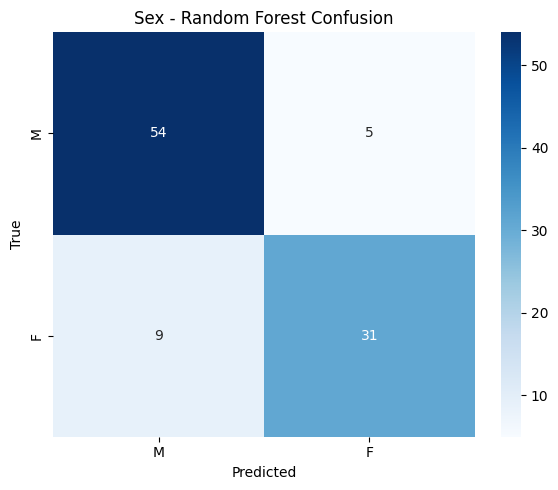

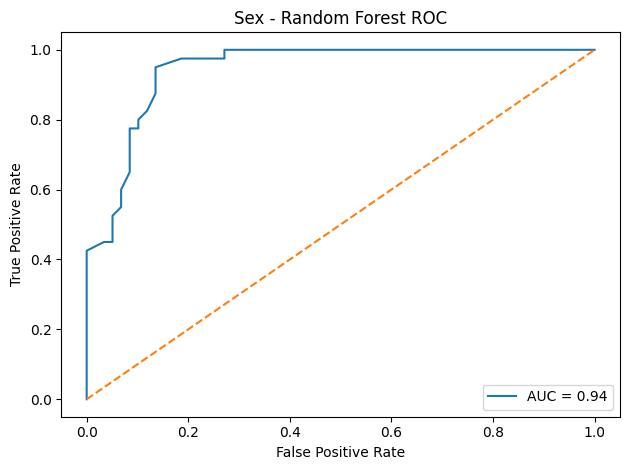

              precision    recall  f1-score   support

           M       0.86      0.92      0.89        59
           F       0.86      0.78      0.82        40

    accuracy                           0.86        99
   macro avg       0.86      0.85      0.85        99
weighted avg       0.86      0.86      0.86        99

AUC: 0.94

=== Sex | Logistic Regression ===


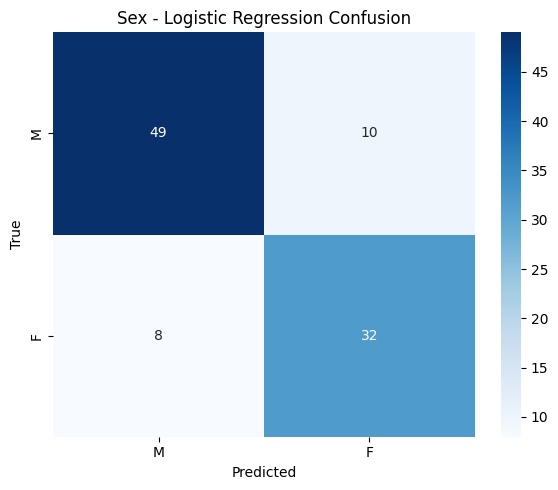

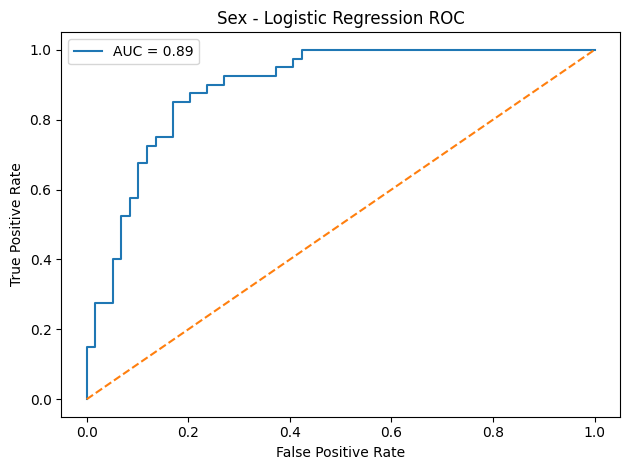

              precision    recall  f1-score   support

           M       0.86      0.83      0.84        59
           F       0.76      0.80      0.78        40

    accuracy                           0.82        99
   macro avg       0.81      0.82      0.81        99
weighted avg       0.82      0.82      0.82        99

AUC: 0.89

=== Sex | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:05:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


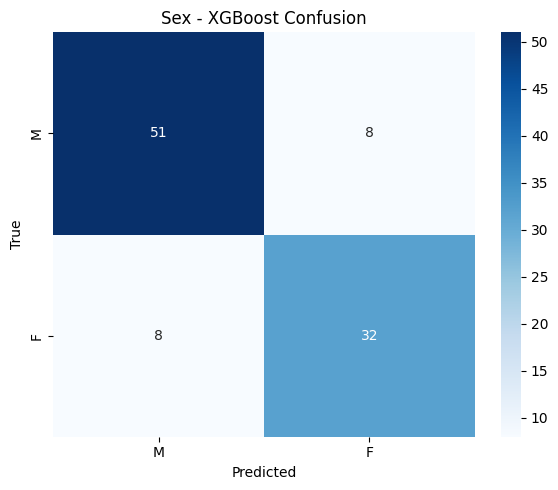

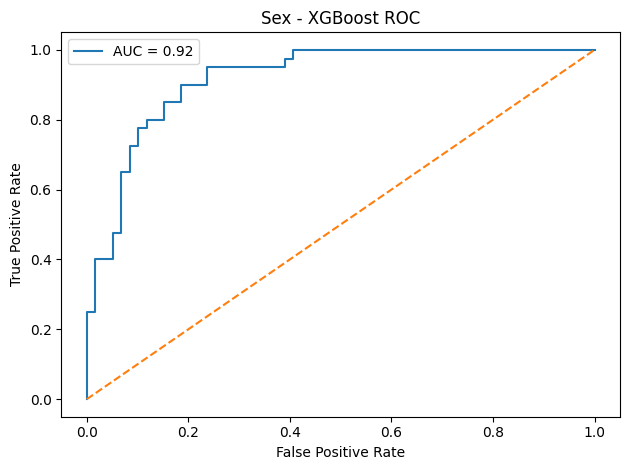

              precision    recall  f1-score   support

           M       0.86      0.86      0.86        59
           F       0.80      0.80      0.80        40

    accuracy                           0.84        99
   macro avg       0.83      0.83      0.83        99
weighted avg       0.84      0.84      0.84        99

AUC: 0.92

=== MGMT status | Random Forest ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


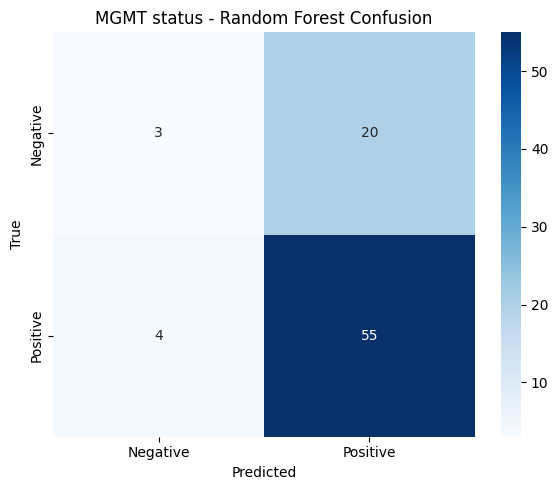

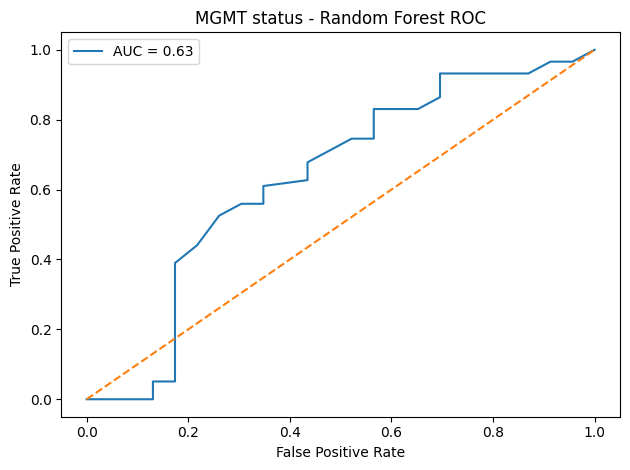

              precision    recall  f1-score   support

    Negative       0.43      0.13      0.20        23
    Positive       0.73      0.93      0.82        59

    accuracy                           0.71        82
   macro avg       0.58      0.53      0.51        82
weighted avg       0.65      0.71      0.65        82

AUC: 0.63

=== MGMT status | Logistic Regression ===


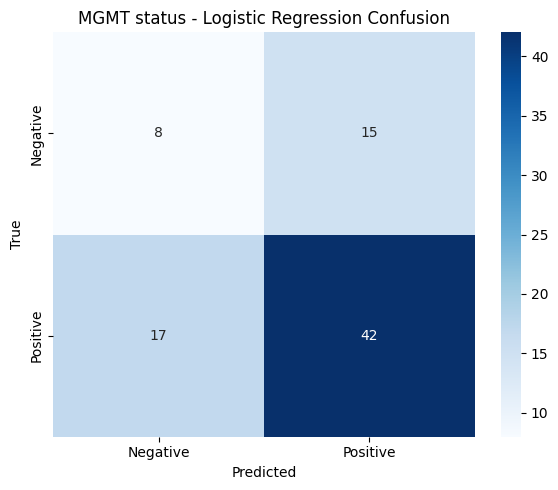

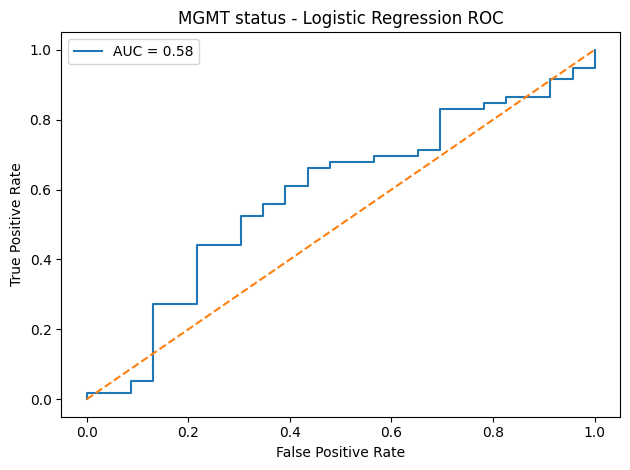

              precision    recall  f1-score   support

    Negative       0.32      0.35      0.33        23
    Positive       0.74      0.71      0.72        59

    accuracy                           0.61        82
   macro avg       0.53      0.53      0.53        82
weighted avg       0.62      0.61      0.61        82

AUC: 0.58

=== MGMT status | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:05:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


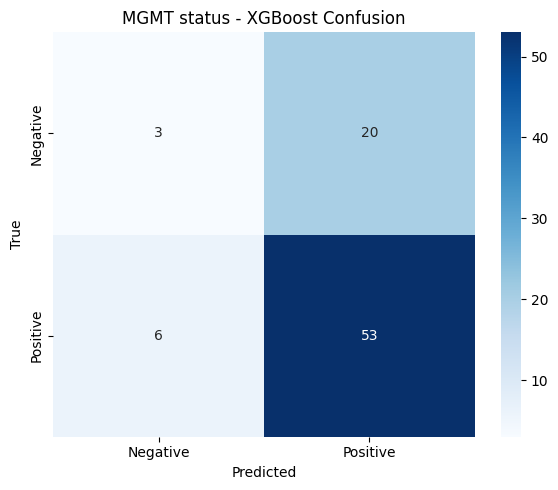

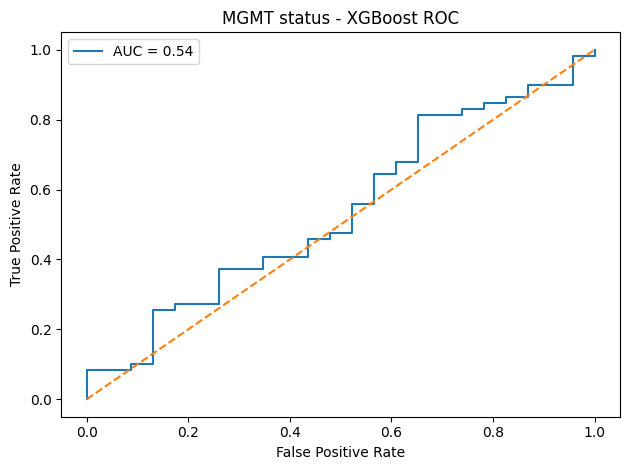

              precision    recall  f1-score   support

    Negative       0.33      0.13      0.19        23
    Positive       0.73      0.90      0.80        59

    accuracy                           0.68        82
   macro avg       0.53      0.51      0.50        82
weighted avg       0.62      0.68      0.63        82

AUC: 0.54

=== IDH mutation status | Random Forest ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


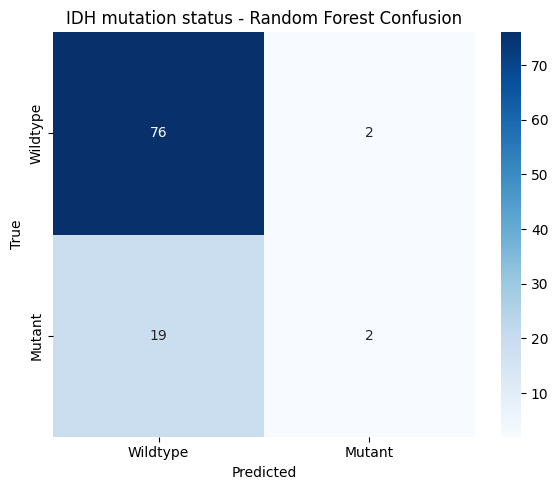

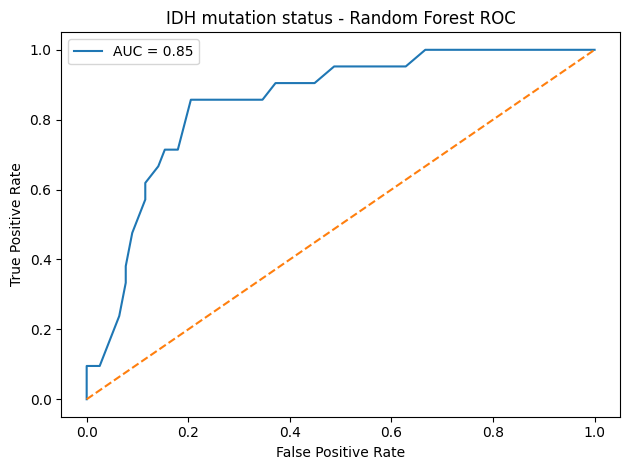

              precision    recall  f1-score   support

    Wildtype       0.80      0.97      0.88        78
      Mutant       0.50      0.10      0.16        21

    accuracy                           0.79        99
   macro avg       0.65      0.53      0.52        99
weighted avg       0.74      0.79      0.73        99

AUC: 0.85

=== IDH mutation status | Logistic Regression ===


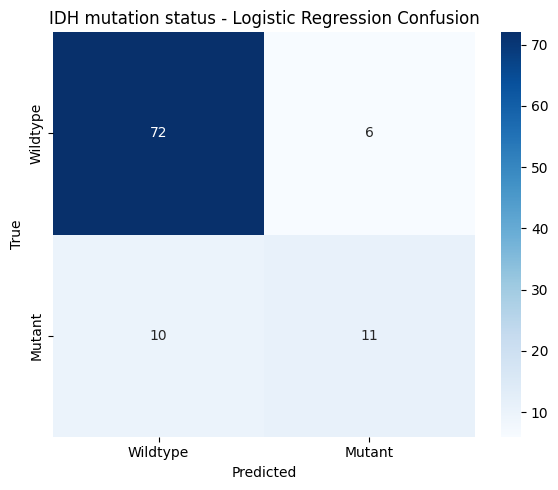

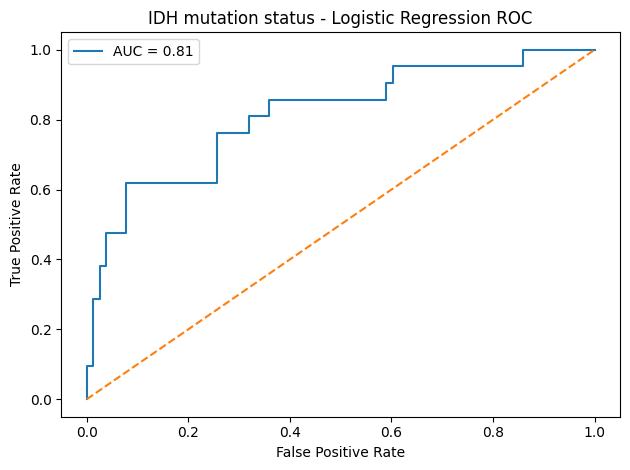

              precision    recall  f1-score   support

    Wildtype       0.88      0.92      0.90        78
      Mutant       0.65      0.52      0.58        21

    accuracy                           0.84        99
   macro avg       0.76      0.72      0.74        99
weighted avg       0.83      0.84      0.83        99

AUC: 0.81

=== IDH mutation status | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:06:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


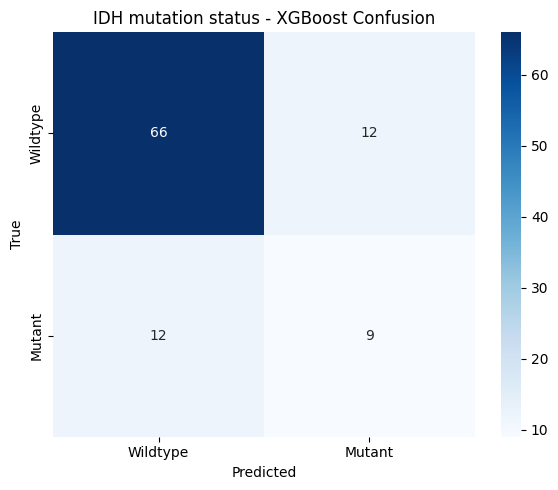

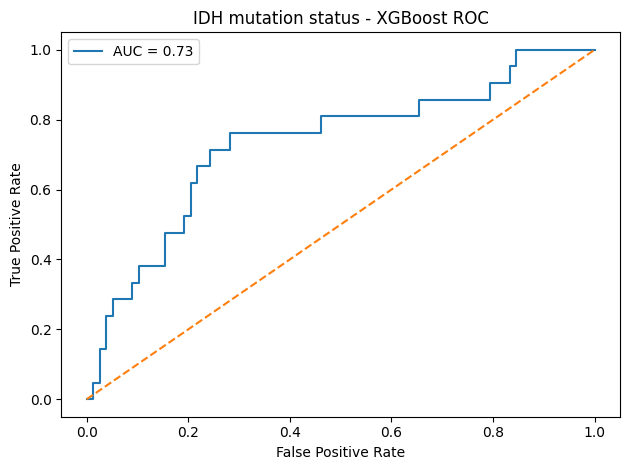

              precision    recall  f1-score   support

    Wildtype       0.85      0.85      0.85        78
      Mutant       0.43      0.43      0.43        21

    accuracy                           0.76        99
   macro avg       0.64      0.64      0.64        99
weighted avg       0.76      0.76      0.76        99

AUC: 0.73

--- Age Regression | Ridge ---
MAE: 10.80
MSE: 188.61
R^2: 0.26


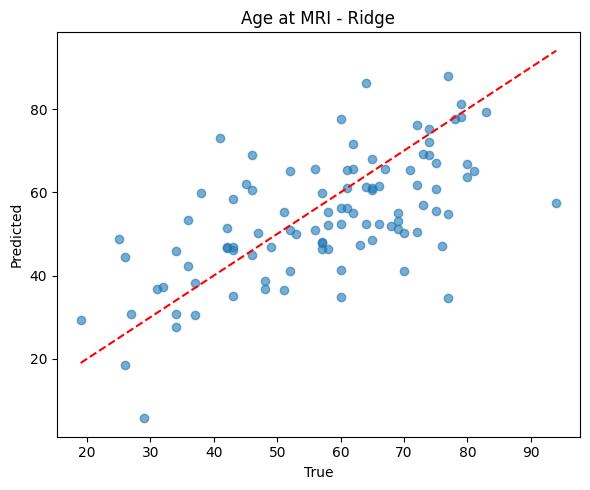


--- Age Regression | Random Forest ---
MAE: 10.78
MSE: 162.31
R^2: 0.37


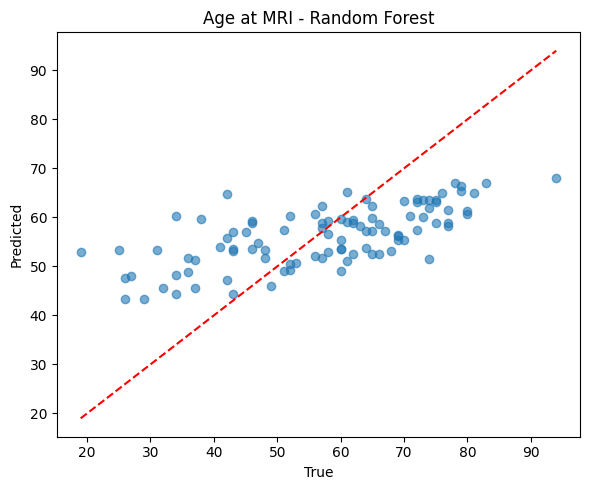


--- Age Regression | XGBoost ---
MAE: 11.00
MSE: 172.27
R^2: 0.33


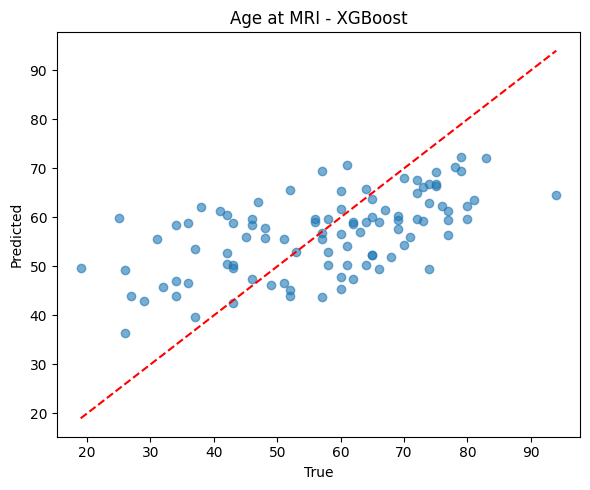


=== OS Cox Regression ===
C-index: 0.654


: 

In [15]:

# --- Plotting Utilities ---
def plot_confusion(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, n_classes=2, title="ROC Curve"):
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return auc_val
    else:
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = {}, {}, {}
        plt.figure()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return roc_auc

# --- Classification Tasks ---
tasks = {
    "Sex": {
        "labels": meta.loc[case_ids, "Sex"].map({"M": 0, "F": 1}).values,
        "class_names": ["M", "F"]
    },
    "MGMT status": {
        "labels": meta.loc[case_ids, "MGMT status"].replace("indeterminate", np.nan).map({"negative": 0, "positive": 1}).values,
        "class_names": ["Negative", "Positive"]
    },
    "IDH mutation status": {
        "labels": np.array([0 if str(v).strip().lower() == "wildtype" else 1 for v in meta.loc[case_ids, "IDH"]]),
        "class_names": ["Wildtype", "Mutant"]
    }
}

for name, info in tasks.items():
    y = info["labels"]
    classes = info["class_names"]
    n_classes = len(set(classes))
    valid_mask = ~pd.isnull(y)
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, stratify=y_valid, test_size=0.2, random_state=42)

    # SMOTE
    class_counts = Counter(y_train)
    min_class_count = min(class_counts.values())
    if len(class_counts) > 1 and min_class_count > 1:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    else:
        print(f"⚠️ Skipping SMOTE for {name}")
        X_train_res, y_train_res = X_train, y_train

    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train_res == 0).sum() / (y_train_res == 1).sum())
    }

    for clf_name, clf in classifiers.items():
        print(f"\n=== {name} | {clf_name} ===")
        if clf_name == "Logistic Regression":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_res)
            X_test_scaled = scaler.transform(X_test)
            clf.fit(X_train_scaled, y_train_res)
            y_pred = clf.predict(X_test_scaled)
            y_score = clf.predict_proba(X_test_scaled)[:, 1] if n_classes == 2 else clf.predict_proba(X_test_scaled)
        else:
            clf.fit(X_train_res, y_train_res)
            y_pred = clf.predict(X_test)
            y_score = clf.predict_proba(X_test)[:, 1] if n_classes == 2 else clf.predict_proba(X_test)

        cm = confusion_matrix(y_test, y_pred)
        plot_confusion(cm, classes, f"{name} - {clf_name} Confusion")
        auc_val = plot_roc(y_test, y_score, n_classes=n_classes, title=f"{name} - {clf_name} ROC")
        print(classification_report(y_test, y_pred, target_names=[str(c) for c in classes]))
        if isinstance(auc_val, dict):
            for cls_idx, val in auc_val.items():
                print(f"AUC (Class {cls_idx}): {val:.2f}")
        else:
            print(f"AUC: {auc_val:.2f}")

# --- Age Regression ---
age = meta.loc[case_ids, "Age at MRI"].astype(float).values
valid_mask = ~pd.isnull(age)
X_age, y_age = X[valid_mask], age[valid_mask]
X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressors = {
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
}

for name, model in regressors.items():
    print(f"\n--- Age Regression | {name} ---")
    if name == "Ridge":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R^2: {r2_score(y_test, y_pred):.2f}")
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Age at MRI - {name}")
    plt.tight_layout()
    plt.show()

# --- OS Survival Analysis with PCA-reduced Cox ---
os_time = meta.loc[case_ids, "OS"]
os_event = np.ones_like(os_time)  # placeholder: all uncensored
valid_mask = ~pd.isnull(os_time)
X_os = X[valid_mask]
y_os_time = os_time[valid_mask]
y_os_event = os_event[valid_mask]

scaler = StandardScaler()
X_os_scaled = scaler.fit_transform(X_os)
pca = PCA(n_components=20)
X_os_reduced = pca.fit_transform(X_os_scaled)

cox_df = pd.DataFrame(X_os_reduced, columns=[f"PC{i+1}" for i in range(X_os_reduced.shape[1])])
cox_df["duration"] = y_os_time.values
cox_df["event"] = y_os_event

cph = CoxPHFitter()
cph.fit(cox_df, duration_col="duration", event_col="event")
c_index = cph.concordance_index_
print(f"\n=== OS Cox Regression ===\nC-index: {c_index:.3f}")


In [ ]:
## UMAP VIZ

# --- Load features and metadata ---
data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/pdgm_mae_features_idh_full1e4lr1600.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv").set_index("ID")

# --- Standardize features and run UMAP ---
X_scaled = StandardScaler().fit_transform(X)
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# --- Metadata columns to visualize ---
columns = [
    "ID", "Sex", "Age at MRI", "WHO CNS Grade", "Final pathologic diagnosis (WHO 2021)",
    "MGMT status", "MGMT index", "1p/19q", "IDH", "1-dead 0-alive", "OS", "EOR",
    "Biopsy prior to imaging", "BraTS21 ID", "BraTS21 Segmentation Cohort", "BraTS21 MGMT Cohort"
]

os.makedirs("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/umap_plots/PDGM", exist_ok=True)

for column in columns:
    try:
        values = meta.loc[case_ids, column].values
    except KeyError:
        print(f"Column {column} not found in metadata.")
        continue

    # Convert all values to string, replace nan with "NA"
    values_str = np.array([str(v) if pd.notna(v) else "NA" for v in values])

    plt.figure(figsize=(7, 6))
    for val in np.unique(values_str):
        idx = values_str == val
        plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=str(val), alpha=0.7, s=20)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"UMAP colored by {column}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.savefig(f"/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/umap_plots/PDGM/umap_{column.replace(' ', '_').replace('/', '_')}.png")
    plt.close()
    print(f"Saved UMAP for {column}")

print("All UMAP plots saved")

In [ ]:
###### TSNE VIZ
# --- Load features and metadata ---
data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/pdgm_mae_features_idh_full1e4lr1600.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv").set_index("ID")

# --- Standardize features and run t-SNE ---
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# --- Metadata columns to visualize ---
columns = [
    "ID", "Sex", "Age at MRI", "WHO CNS Grade", "Final pathologic diagnosis (WHO 2021)",
    "MGMT status", "MGMT index", "1p/19q", "IDH", "1-dead 0-alive", "OS", "EOR",
    "Biopsy prior to imaging", "BraTS21 ID", "BraTS21 Segmentation Cohort", "BraTS21 MGMT Cohort"
]

os.makedirs("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/tsne_plots/PDGM", exist_ok=True)

for column in columns:
    try:
        values = meta.loc[case_ids, column].values
    except KeyError:
        print(f"Column {column} not found in metadata.")
        continue

    # Convert all values to string, replace nan with "NA"
    values_str = np.array([str(v) if pd.notna(v) else "NA" for v in values])

    plt.figure(figsize=(7, 6))
    for val in np.unique(values_str):
        idx = values_str == val
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=str(val), alpha=0.7, s=20)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"t-SNE colored by {column}")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.tight_layout()
    plt.savefig(f"/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/tsne_plots/PDGM/tsne_{column.replace(' ', '_').replace('/', '_')}.png")
    plt.close()
    print(f"Saved t-SNE for {column}")

print("All t-SNE plots saved")
